In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
# Import helper module from local folder
import sys
import os
sys.path.append(os.getcwd()) 


In [2]:
from resources import helper

# Numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel
from qiskit.pulse import DriveChannel, Gaussian
from qiskit.tools.monitor import job_monitor
from resources.helper import SpecFitter
from qiskit.ignis.characterization.calibrations.fitters import RabiFitter

# Import SI unit conversion factors
from resources.helper import GHz, MHz, kHz, us, ns

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## Account  and Provider Setting¶


In [3]:
# Get the special provider assigned to you using information from the output above
hub_name = 'iqc2021-5' # e.g. 'iqc2021-1'
group_name = 'challenge-90' # e.g. 'challenge-1'
project_name = 'ex4' # Your project name should be 'ex4'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Get `ibmq_jakarta` backend from the provider
backend_name = 'ibmq_jakarta'
backend = provider.get_backend(backend_name)
backend # See details of the `ibmq_jakarta` quantum system

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='iqc2021-5', group='challenge-90', project='ex4')>

# 1. Instantiate channels and retrieve measurement schedule

We will use the same measurement schedule throughout, whereas the drive schedules will vary. For any backend, we can ask for its default measurement pulse instead of calibrating it separately.

In [7]:
qubit = 0

Next, save the backend configuration and the sampling time 𝑑𝑡. We will exclude the AcquireChannels when plotting for clarity.

In [4]:
backend_config = backend.configuration()
exc_chans = helper.get_exc_chans(globals())
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


The instruction_schedule_map provides the parameters of the default calibrated pulses used by the backend. In particular, we see that this "native gate set" consists of a subset of operations you can perform on a QuantumCircuit, and is the gate set that the QuantumCircuit is transpiled to by Qiskit.

In [5]:
backend_defaults = backend.defaults()
center_frequency = backend_defaults.qubit_freq_est
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

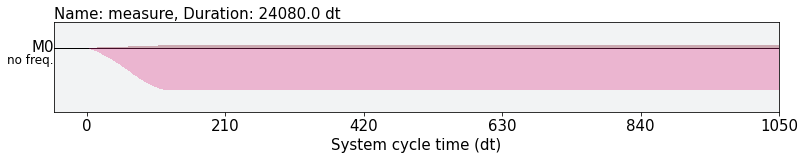

In [8]:
# Retrieve calibrated measurement pulse from backend
meas = inst_sched_map.get('measure', qubits=[qubit])
meas.exclude(channels=exc_chans).draw(time_range=[0,1000])

# 2. |0> - |1>

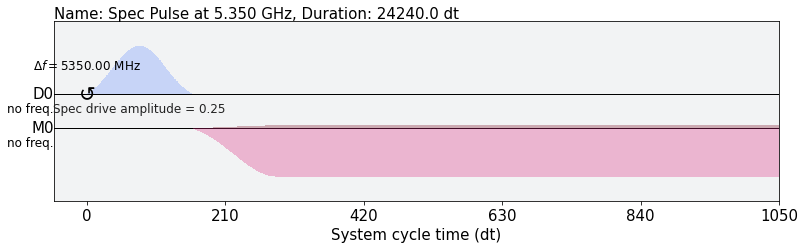

In [9]:
from qiskit.pulse import DriveChannel, Gaussian

# The same spec pulse for both 01 and 12 spec
drive_amp = 0.25
drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration

# Calibrated backend pulse use advanced DRAG pulse to reduce leakage to the |2> state.
# Here we will use simple Gaussian pulse

drive_sigma = drive_duration // 4 # DRAG pulses typically 4*sigma long. 
spec_pulse = Gaussian(duration=drive_duration, amp=drive_amp, 
                        sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")

# Construct an np array of the frequencies for our experiment
spec_freqs_GHz = helper.get_spec01_freqs(center_frequency, qubit)

# Create the base schedule
# Start with drive pulse acting on the drive channel
spec01_scheds = []
for freq in spec_freqs_GHz:
    with pulse.build(name="Spec Pulse at %.3f GHz" % freq) as spec01_sched:
        with pulse.align_sequential():
            # Pay close attention to this part to solve the problem at the end
            pulse.set_frequency(freq*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(meas)
            
    spec01_scheds.append(spec01_sched)

# Draw spec01 schedule
spec01_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [10]:
from qiskit.tools.monitor import job_monitor

# Run the job on a real backend
spec01_job = backend.run(spec01_scheds, job_name="Spec 01", **helper.job_params) 

print(spec01_job.job_id())
job_monitor(spec01_job)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60afaa4b5255f052d538762c
Job Status: job has successfully run


Fit the Spectroscopy Data
We will fit the spectroscopy signal to a Lorentzian function of the form

𝐴𝐵𝜋[(𝑓−𝑓01)2+𝐵2]+𝐶
to find the qubit frequency 𝑓01 with these fitting parameters:

Parameter	Corresponds to
𝐴	amplitude
𝑓01	01 frequency guess (GHz)
𝐵	scale
𝐶	offset

Spec01 frequency is 5.237453 GHz


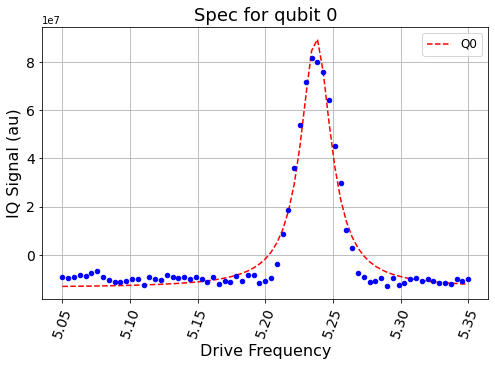

In [11]:
from resources.helper import SpecFitter

amp_guess = 5e6
f01_guess = 5
B = 1
C = 0
fit_guess = [amp_guess, f01_guess, B, C]

fit = SpecFitter(spec01_job.result(), spec_freqs_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f01 = fit.spec_freq(0, series='z')
print("Spec01 frequency is %.6f GHz" % f01)

In [12]:
# Retrieve qubit frequency from backend properties
f01_calibrated = backend.properties().frequency(qubit) / GHz 
f01_error = abs(f01-f01_calibrated) * 1000 # error in MHz
print("Qubit frequency error is %.6f MHz" % f01_error) 

Qubit frequency error is 1.060183 MHz


# 3. Calibrate X-180 pulse amplitude using Rabi oscillation

### Build Rabi schedule from measured frequency


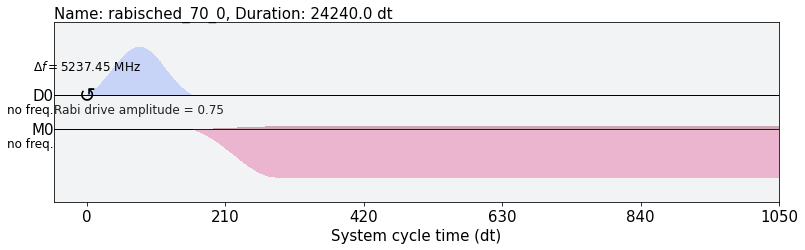

In [14]:
max_rabi_amp = 0.75
rabi_amps = helper.get_rabi_amps(max_rabi_amp)

rabi_scheds = []
for ridx, amp in enumerate(rabi_amps):
    with pulse.build(name="rabisched_%d_0" % ridx) as sched: # '0' corresponds to Rabi
        with pulse.align_sequential():
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            rabi_pulse = Gaussian(duration=drive_duration, amp=amp, \
                              sigma=drive_sigma, name=f"Rabi drive amplitude = {amp}")
            pulse.play(rabi_pulse, DriveChannel(qubit))
            pulse.call(meas)
    rabi_scheds.append(sched)

# Draw rabi schedule
rabi_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [15]:
# Run the job on a real device
rabi_job = backend.run(rabi_scheds, job_name="Rabi", **helper.job_params)

print(rabi_job.job_id())
job_monitor(rabi_job)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60afab3bd3cf25153d44c354
Job Status: job has successfully run


Fit the Rabi Data
We will fit the Rabi signal to a sinusoidal function of the form

𝑎cos(2𝜋𝑓𝑥+𝜙)+𝑐
to find the Rabi period 𝑇=2𝜋/𝑓 with these fitting parameters:

Parameter	Corresponds to
𝑎	amplitude
𝑓	Rabi drive frequency
𝜙	phase offset
𝑐	offset

Pi amplitude is 0.206


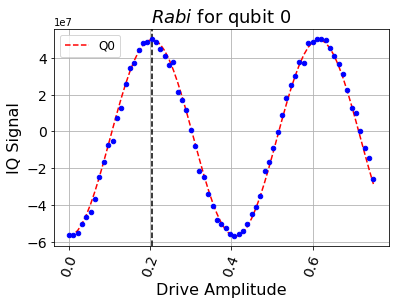

In [16]:
from qiskit.ignis.characterization.calibrations.fitters import RabiFitter

amp_guess = 5e7
fRabi_guess = 2
phi_guess = 0.5
c_guess = 0
fit_guess = [amp_guess, fRabi_guess, phi_guess, c_guess]

fit = RabiFitter(rabi_job.result(), rabi_amps, qubits=[qubit], fit_p0=fit_guess)
fit.plot(qind=0, series='0')
x180_amp = fit.pi_amplitude()
print("Pi amplitude is %.3f" % x180_amp)

# 4.|1> - |2>

In order to observe the transition between the $|1\rangle$ and $|2\rangle$ states of the transmon, you need to: 

1. Apply an $X_\pi$ pulse to transition the qubit from $|0\rangle$ to $|1\rangle$.
1. Apply a second pulse with varying frequency to find the $|1\rangle \rightarrow |2\rangle$ transition.

In [38]:
# Define pi pulse
x_pulse = Gaussian(duration=drive_duration,
                     amp=x180_amp, 
                     sigma=drive_sigma,
                     name='x_pulse')

def build_spec12_pulse_schedule(freq, anharm_guess_GHz):    
    with pulse.build(name="Spec Pulse at %.3f GHz" % (freq+anharm_guess_GHz)) as spec12_schedule:
        with pulse.align_sequential(): 
            
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))                
            pulse.play(x_pulse, DriveChannel(qubit))

            
            pulse.set_frequency((freq+anharm_guess_GHz)*GHz, DriveChannel(qubit))
            pulse.play(x_pulse, DriveChannel(qubit))
            pulse.call(meas)
            

    return spec12_schedule

The anharmonicity of our transmon qubits is typically around −300 MHz, so we will sweep around that value.

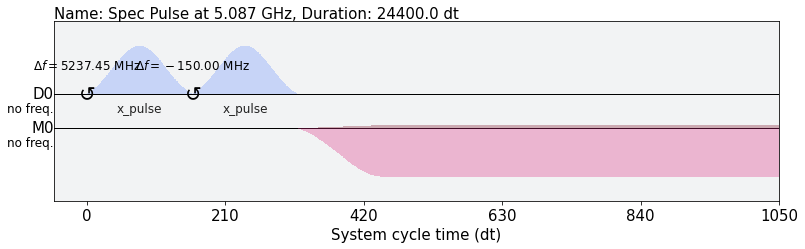

In [39]:
anharmonicity_guess_GHz = -0.3 # your anharmonicity guess
freqs_GHz = helper.get_spec12_freqs(f01, qubit)

# Now vary the sideband frequency for each spec pulse
spec12_scheds = []
for freq in freqs_GHz:
    spec12_scheds.append(build_spec12_pulse_schedule(freq, anharmonicity_guess_GHz))

# Draw spec12 schedule   
spec12_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [40]:
# Run the job on a real device
spec12_job = backend.run(spec12_scheds, job_name="Spec 12", **helper.job_params)

print(spec12_job.job_id())
job_monitor(spec12_job)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60afad3de42d8427db77a2e1
Job Status: job has successfully run


Fit the Spectroscopy Data
We will again fit the spectroscopy signal to a Lorentzian function of the form

𝐴𝐵𝜋[(𝑓−𝑓12)2+𝐵2]+𝐶
to find the frequency of the |1⟩→|2⟩ transition 𝑓12 with these fitting parameters:

Parameter	Corresponds to
𝐴	amplitude
𝑓12	12 frequency guess (GHz)
𝐵	scale
𝐶	offset

Spec12 frequency is 4.897988 GHz


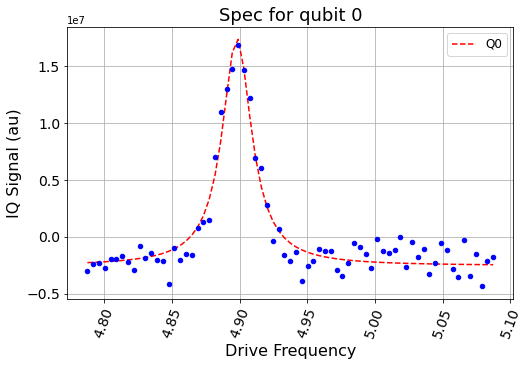

In [41]:
amp_guess = 2e7
f12_guess = f01 - 0.3
B = .1
C = 0
fit_guess = [amp_guess, f12_guess, B, C]

fit = SpecFitter(spec12_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

# 5. Grading

In [42]:
# Check your answer using following code
from qc_grader import grade_ex4
grade_ex4(f12,qubit,backend_name)

Grading your answer for ex4. Please wait...

Congratulations 🎉! Your answer is correct.
Feel free to submit your answer.

